#Hybrid Model on PolitiFact Dataset

The Hybrid model is created as a combination of the DeClarE model (Popat et al.,2018) and Self-Attentive Sentence Embedding model (Lin et al.,2017). This model uses the overall structure of DeClarE but replaces its attention mechanism with the Self-attention created in the second paper. The code for the Self-Attention model can be found at: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master . This code have been used as the base for the Hybrid model. Before running the code in Google Colab, please upload the config.json and model_params.json file which is provided as a part of the project code zip file. Both of these file contain the hyper-parameters of the model and were originally created by the developer of this code base.

## Import Statements and Data load

In [1]:
# Most of the code taken from https://github.com/kaushalshetty/Structured-Self-Attention/blob/master
# All imports
import json
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import gzip

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.utils import np_utils

from keras.optimizers import SGD, Adam
from nltk import word_tokenize
import matplotlib.pyplot as plt

import torch,keras
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as data_utils
from keras.datasets import imdb

import random, os, numpy, scipy
from codecs import open
import os,sys

Using TensorFlow backend.


In [0]:
# Random seed set to ensure that code provides the same output whenever randomisation is done.
seed = 7
np.random.seed(seed)

In [3]:
# Get the PolitiFact Dataset from the location provided in the DeClarE paper.
!wget http://resources.mpi-inf.mpg.de/impact/dl_cred_analysis/PolitiFact.zip
!unzip PolitiFact.zip

--2019-08-31 13:30:49--  http://resources.mpi-inf.mpg.de/impact/dl_cred_analysis/PolitiFact.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4976217 (4.7M) [application/zip]
Saving to: ‘PolitiFact.zip’

PolitiFact.zip      100%[===================>]   4.75M  5.46MB/s    in 0.9s    

2019-08-31 13:30:50 (5.46 MB/s) - ‘PolitiFact.zip’ saved [4976217/4976217]

Archive:  PolitiFact.zip
   creating: PolitiFact/
  inflating: PolitiFact/README       
  inflating: PolitiFact/politifact.tsv  


In [4]:
# Download the Glove.zip file and expand it.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2019-08-31 13:30:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-31 13:30:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-31 13:30:56--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

## Data Load functions and other misc functions

In [0]:
# Method to load the PolitiFact into the Datafarme, process it and divide it into traning and test sets.
def loadPolitifact():
  facts=list()
  fact=pd.read_csv('./PolitiFact/politifact.tsv', delimiter = '\t', names = ['cred_label','claim_id','claim_text','claim_source','article','article_source'])
  
  # Convert label to binary
  claim_label = fact['cred_label']
  # The original credibility labels are -{'False', 'Half-True', 'Mostly False', 'Mostly True', 'Pants on Fire!', 'True'}
  # Convert the labels to binary values of 0 for false and 1 for true.
  claim_label = [1 if tuple == 'True'  or tuple == 'Half-True' or tuple == 'Mostly True' else 0 for tuple in claim_label]
  
  # Get Train and test sets
  input_train,input_test,label_train,label_test = train_test_split(fact, claim_label, test_size=0.2, random_state=8)
  # Convert the traning and test data as lists and return.
  train_list= list()
  train_list.append(input_train)
  train_list.append(label_train)
  
  test_list = list()
  test_list.append(input_test)
  test_list.append(label_test)
  return train_list, test_list

In [0]:
# Get Politifact dataset. This method calls the previous method
def load_data_set(type,max_len,vocab_size,batch_size):
    """
        Loads the dataset.
 
        Args:
            type   : {bool} 0 for binary classification returns imdb dataset. 1 for multiclass classfication return reuters set
            max_len: {int} timesteps used for padding
			vocab_size: {int} size of the vocabulary
			batch_size: batch_size
      
        """
    NUM_WORDS=vocab_size
    # Get the PolitiFact dataframe 
    train_set,test_set = loadPolitifact()
    x_train,y_train = train_set[0],train_set[1]
    x_test,y_test = test_set[0],test_set[1]

    # Code to check how many unique claims are present in the test set.
    # Code found here: https://stackoverflow.com/questions/23460345/selecting-unique-rows-between-two-dataframes-in-pandas
    unique_test = x_test[~x_test['claim_text'].isin(x_train['claim_text'])]
    uniq_set = set(unique_test['claim_text'].tolist())
    print("There are %d total unique rows in the test set and %d unique claims" % (len(unique_test),len(uniq_set)))
    # Get the required columns as lists for both traning and test data
    art_list = x_train['article'].tolist()
    clm_list = x_train['claim_text'].tolist()
    clm_src_list = x_train['claim_source'].tolist()
    art_src_list = x_train['article_source'].tolist()
    
    test_art_list = x_test['article'].tolist()
    test_clm_list = x_test['claim_text'].tolist()
    test_clm_src_list = x_test['claim_source'].tolist()
    test_art_src_list = x_test['article_source'].tolist()

    # Text to Sequence conversion
    t = Tokenizer()
    t.fit_on_texts(clm_list+art_list+clm_src_list+art_src_list)
    t.num_words=NUM_WORDS
    encoded_claim = t.texts_to_sequences(clm_list) # claim
    encoded_art = t.texts_to_sequences(art_list) # article
    encoded_claim_src = t.texts_to_sequences(clm_src_list) # claim source
    encoded_art_src = t.texts_to_sequences(art_src_list) # article source
    
    encoded_claim_test = t.texts_to_sequences(test_clm_list)
    encoded_art_test = t.texts_to_sequences(test_art_list)
    encoded_claim_src_test = t.texts_to_sequences(test_clm_src_list)
    encoded_art_src_test = t.texts_to_sequences(test_art_src_list)
    
    word_to_id = t.word_index

    # Add a padding of 150 to article and 50 to claim. Padding of 8 given to article source.
    # This is done for the training data.
    x_train_pad_cl = pad_sequences(encoded_claim, maxlen=50, padding='post') # claim padding
    x_train_pad = pad_sequences(encoded_art, maxlen=max_len, padding='post') # article padding
    x_train_pad_cls = pad_sequences(encoded_claim_src, maxlen=4, padding='post') # claim source padding
    x_train_pad_s = pad_sequences(encoded_art_src, maxlen=4, padding='post') # article source padding
    
    # Test padding
    x_test_pad_cl = pad_sequences(encoded_claim_test, maxlen=50, padding='post')
    x_test_pad = pad_sequences(encoded_art_test, maxlen=max_len, padding='post')
    x_test_pad_cls= pad_sequences(encoded_claim_src_test, maxlen=4, padding='post')
    x_test_pad_s = pad_sequences(encoded_art_src_test, maxlen=4, padding='post')
    # Covert training data to a Numpy array
    x_train_pad_np_cl = np.array(x_train_pad_cl, dtype=np.float32) # claim numpy
    x_train_pad_np = np.array(x_train_pad, dtype=np.float32) # article numpy
    x_train_pad_np_cls = np.array(x_train_pad_cls, dtype=np.float32) # claim source numpy
    x_train_pad_np_s = np.array(x_train_pad_s, dtype=np.float32) # article source numpy
    
    # Test data numpy
    x_test_pad_np_cl = np.array(x_test_pad_cl, dtype=np.float32)
    x_test_pad_np = np.array(x_test_pad, dtype=np.float32)
    x_test_pad_np_cls = np.array(x_test_pad_cls, dtype=np.float32)
    x_test_pad_np_s = np.array(x_test_pad_s, dtype=np.float32)
    
    y_train_np = np.array(y_train, dtype=np.float32)
    y_test_np = np.array(y_test, dtype=np.float32)
    # Convert the training data to a Tensor Variable to be used by the Hybrid model.
    train_data = data_utils.TensorDataset(torch.from_numpy(x_train_pad_np_cl).type(torch.LongTensor),
                                          torch.from_numpy(x_train_pad_np).type(torch.LongTensor),
                                          torch.from_numpy(x_train_pad_np_cls).type(torch.LongTensor),
                                          torch.from_numpy(x_train_pad_np_s).type(torch.LongTensor),
                                          torch.from_numpy(y_train_np).type(torch.DoubleTensor))
    train_loader = data_utils.DataLoader(train_data,batch_size=batch_size,drop_last=True)
    return train_loader, x_test_pad_np_cl, x_test_pad_np,x_test_pad_np_cls, x_test_pad_np_s, y_test_np, word_to_id, x_test, x_train

In [0]:
# Get the embedding matrix using Glove. 
vocab,word2idx = None,{}

def load_glove_embeddings(path, word2idx, embedding_dim):
    """Loading the glove embeddings"""
    vocab_size = len(word2idx) + 1
    with open(path) as f:
        embeddings = np.zeros((vocab_size, embedding_dim))
        for line in f.readlines():
            values = line.split()
            word = values[0]
            index = word2idx.get(word)
            if index:
                vector = np.array(values[1:], dtype='float32')
                if vector.shape[-1] != embedding_dim:
                    raise Exception('Dimension not matching.')
                embeddings[index] = vector
        return torch.from_numpy(embeddings).float()

In [8]:
# Method to read and store the contents of the uploaded json files.
def json_to_dict(json_set):
    for k,v in json_set.items():
        if v == 'False':
            json_set[k] = False
        elif v == 'True':
            json_set[k] = True
        else:
            json_set[k] = v
    return json_set

  
with open('config.json', 'r') as f:
    params_set = json.load(f)

with open('model_params.json', 'r') as f:
    model_params = json.load(f)

params_set = json_to_dict(params_set)
model_params = json_to_dict(model_params)
 
print("Using settings:",params_set)
print("Using model settings",model_params)

Using settings: {'epochs': 2, 'use_regularization': True, 'C': 0.03, 'clip': True, 'use_embeddings': True, 'attention_hops': 10}
Using model settings {'batch_size': 512, 'vocab_size': 20000, 'timesteps': 100, 'lstm_hidden_dimension': 50, 'd_a': 100}


In [0]:
#Creates and HTML file which show the attention weights visulaization on the article. This code taken from: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master

def createHTML(texts, weights, fileName):
    """
    Creates a html file with text heat.
	weights: attention weights for visualizing
	texts: text on which attention weights are to be visualized
    """
    fileName = "visualization/"+fileName
    fOut = open(fileName, "w", encoding="utf-8")
    part1 = """
    <html lang="en">
    <head>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <style>
    body {
    font-family: Sans-Serif;
    }
    </style>
    </head>
    <body>
    <h3>
    Heatmaps
    </h3>
    </body>
    <script>
    """
    part2 = """
    var color = "255,0,0";
    var ngram_length = 3;
    var half_ngram = 1;
    for (var k=0; k < any_text.length; k++) {
    var tokens = any_text[k].split(" ");
    var intensity = new Array(tokens.length);
    var max_intensity = Number.MIN_SAFE_INTEGER;
    var min_intensity = Number.MAX_SAFE_INTEGER;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = 0.0;
    for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
    if (i+j < intensity.length && i+j > -1) {
    intensity[i] += trigram_weights[k][i + j];
    }
    }
    if (i == 0 || i == intensity.length-1) {
    intensity[i] /= 2.0;
    } else {
    intensity[i] /= 3.0;
    }
    if (intensity[i] > max_intensity) {
    max_intensity = intensity[i];
    }
    if (intensity[i] < min_intensity) {
    min_intensity = intensity[i];
    }
    }
    var denominator = max_intensity - min_intensity;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = (intensity[i] - min_intensity) / denominator;
    }
    if (k%2 == 0) {
    var heat_text = "<p><br><b>Example:</b><br>";
    } else {
    var heat_text = "<b>Example:</b><br>";
    }
    var space = "";
    for (var i = 0; i < tokens.length; i++) {
    heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>" + space + tokens[i] + "</span>";
    if (space == "") {
    space = " ";
    }
    }
    //heat_text += "<p>";
    document.body.innerHTML += heat_text;
    }
    </script>
    </html>"""
    putQuote = lambda x: "\"%s\""%x
    textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
    weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
    fOut.write(part1)
    fOut.write(textsString)
    fOut.write(weightsString)
    fOut.write(part2)
    fOut.close()
  
    return

In [0]:
# Create a new directory called visualization.
!mkdir visualization

In [11]:
# Call the method to load the Snopes dataset and embedding matrix
MAXLENGTH = 150
train_loader,x_test_pad_cl,x_test_pad,x_test_pad_cls,x_test_pad_s,y_test,word_to_id,x_test_or,x_train_or = load_data_set(0,MAXLENGTH,
                                                                                                                         model_params["vocab_size"],
                                                                                                                         model_params['batch_size']) #loading snopes dataset  

embeddings = load_glove_embeddings("glove.6B.50d.txt",word_to_id,50)

cred_label                                                Half-True
claim_id          2013_feb_12_barack-obama_barack-obama-touts-ad...
claim_text        says administration made progress border enfor...
claim_source                                           barack obama
article           obama said the overhaul measure should cut wai...
article_source                                              bna.com
Name: 21584, dtype: object
There are 159 total unique rows in the test set and 138 unique claims


## Structured Self Attention Model Full

In [0]:
# Structured Self Attention class. This class reprsents the Hybrid model. Most of this clas is taken from: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master
 
class StructuredSelfAttention(torch.nn.Module):
    """
    The class is an implementation of the paper A Structured Self-Attentive Sentence Embedding including regularization
    and without pruning. Slight modifications have been done for speedup
    """
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()
         # Model layers initialization
        self.embeddings,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first.bias.data.fill_(0)
        self.linear_second = torch.nn.Linear(d_a,r)
        self.linear_second.bias.data.fill_(0)
        self.n_classes = n_classes
        
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)
        
        self.embeddings3,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.embeddings4,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        
        self.linear_penul = torch.nn.Linear(3*lstm_hid_dim,8)
        self.linear_final = torch.nn.Linear(8,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
        
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")

        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,xs,ys):
        embeddings = self.embeddings(x) # claim embedding
        embeddings_part_y = self.embeddings(y[:,:100]) # article embedding taking the first 100
        main_embedding  = torch.cat((embeddings, embeddings_part_y), 1) # concatination of the two
        # Bi-LSTM layer
        outputs, self.hidden_state = self.lstm(main_embedding.view(self.batch_size,self.max_len,-1),self.hidden_state)
        # Self-Attention mechanism 
        x = torch.tanh(self.linear_first(outputs))       
        x = self.linear_second(x)       
        x = self.softmax(x,1)       
        attention = x.transpose(1,2)  
        sentence_embeddings = attention@outputs
        # Same processed followed for article only input
        embeddings2 = self.embeddings2(y)    
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state)       
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2
        # Element-wise multiplication of the two outputs
        ele_mul = sentence_embeddings * sentence_embeddings2
        # Average of the output
        avg_sentence_embeddings = torch.sum(ele_mul,1)/self.r
        # Claim and article source embedding. 
        embeddings3 = self.embeddings3(xs)
        embeddings4 = self.embeddings4(ys) 
        # Average of these embeddings
        avg_csource_embeddings = torch.sum(embeddings3,1)/self.r
        avg_asource_embeddings = torch.sum(embeddings4,1)/self.r
        # Combine with the average of the Sef-attention outputs.
        comb_avg = torch.cat((avg_sentence_embeddings, avg_csource_embeddings, avg_asource_embeddings), 1)
        
        dense1 = self.linear_penul(comb_avg) 
        #output = torch.sigmoid(self.linear_final(avg_sentence_embeddings))
        output = torch.sigmoid(self.linear_final(dense1))
        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
 
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [0]:
# Training function that applies the penalization. Most of this code is taken from: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master
 
def train(attention_model,train_loader,criterion,optimizer,epochs = 5,use_regularization = False,C=0,clip=False):
    """
        Training code
 
        Args:
            attention_model : {object} model
            train_loader    : {DataLoader} training data loaded into a dataloader
            optimizer       :  optimizer
            criterion       :  loss function. Must be BCELoss for binary_classification and NLLLoss for multiclass
            epochs          : {int} number of epochs
            use_regularizer : {bool} use penalization or not
            C               : {int} penalization coeff
            clip            : {bool} use gradient clipping or not
       
        Returns:
            accuracy and losses of the model
      
        """
    losses = []
    accuracy = []
    for i in range(epochs):
        print("Running EPOCH",i+1)
        total_loss = 0
        n_batches = 0
        correct = 0
        
        for batch_idx,train in enumerate(train_loader):
            attention_model.hidden_state = attention_model.init_hidden()
            x,x2,xs,x2s,y = Variable(train[0]),Variable(train[1]),Variable(train[2]),Variable(train[3]),Variable(train[4])
            y_pred,att = attention_model(x,x2,xs,x2s)
            
            #penalization AAT - I
            if use_regularization:
                attT = att.transpose(1,2)
                identity = torch.eye(att.size(1))
                identity = Variable(identity.unsqueeze(0).expand(train_loader.batch_size,att.size(1),att.size(1)))
                penal = attention_model.l2_matrix_norm(att@attT - identity)
            
            if not bool(attention_model.type) :
                #binary classification
                #Adding a very small value to prevent BCELoss from outputting NaN's
                correct+=torch.eq(torch.round(y_pred.type(torch.DoubleTensor).squeeze(1)),y).data.sum()
                if use_regularization:
                    try:
                        loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(1)+1e-8,y) + C * penal/train_loader.batch_size
                        
                    except RuntimeError:
                        raise Exception("BCELoss gets nan values on regularization. Either remove regularization or add very small values")
                else:
                    loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(1),y)

            total_loss+=loss.data
            optimizer.zero_grad()
            loss.backward()
            
            #gradient clipping
            if clip:
                torch.nn.utils.clip_grad_norm_(attention_model.parameters(),0.5)
            optimizer.step()
            n_batches+=1
        
        print("avg_loss is",total_loss/n_batches)
        corr_nump = correct.data.cpu().numpy().astype(int)
        acc = corr_nump/float(n_batches*train_loader.batch_size)
        print("Accuracy of the model",acc)
        losses.append(total_loss/n_batches)
        accuracy.append(acc)
    return losses,accuracy

# Evaluate the test result and return the accuracy and the predicted values
def evaluate(attention_model,x_test_cl,x_test,x_test_cls,x_test_s,y_test):
    
    attention_model.batch_size = x_test.shape[0]
    attention_model.hidden_state = attention_model.init_hidden()
    
    x_test_var = Variable(torch.from_numpy(x_test).type(torch.LongTensor)) # article var
    x_test_var_cl = Variable(torch.from_numpy(x_test_cl).type(torch.LongTensor)) # claim var
    x_test_var_s = Variable(torch.from_numpy(x_test_s).type(torch.LongTensor)) # article source var
    x_test_var_cls = Variable(torch.from_numpy(x_test_cls).type(torch.LongTensor)) # claim source var
    y_test_pred,_ = attention_model(x_test_var_cl,x_test_var,x_test_var_cls,x_test_var_s)

    y_preds = torch.round(y_test_pred.type(torch.DoubleTensor).squeeze(1))
    y_test_var = Variable(torch.from_numpy(y_test).type(torch.DoubleTensor))
    sum = torch.eq(y_preds,y_test_var).data.sum()
    total = x_test_var.size(0)
    acc = sum.data.cpu().numpy().astype(int)/float(total)
    return acc, y_preds

def get_activation_wts(attention_model,x,y,xs,ys):
    """
        Get r attention heads
 
        Args:
            attention_model : {object} model
            x               : {torch.Variable} input whose weights we want (claim)
            y               : {torch.Variable} the second input (article)
       
        Returns:
            r different attention weights
 
      
    """
    attention_model.batch_size = x.size(0)
    attention_model.hidden_state = attention_model.init_hidden()
    _,wts = attention_model(x,y,xs,ys)
    return wts

### Model Execution

In [0]:
#Method to process the article and the attention weights then create the HTML file.
def visualize_attention(wts,x_test_pad,word_to_id,filename):
    wts_add = torch.sum(wts,1)
    wts_add_np = wts_add.data.numpy()
    wts_add_list = wts_add_np.tolist()
    id_to_word = {v:k for k,v in word_to_id.items()}
    text= []
    for test in x_test_pad:
        line=list()
        for i in test:
          if i == 0.0:
            word = '<UNK>'
          else:
            word = id_to_word.get(i)
          line.append(word)
        text.append(" ".join(line))

    createHTML(text, wts_add_list, filename)
    print("Attention visualization created for {} samples".format(len(x_test_pad)))
    return

# Method to perform the classification using Binary Cross Entropy Loss and RMSProp optimizer
def binary_classfication(attention_model,train_loader,epochs=5,use_regularization=True,C=1.0,clip=True):
    loss = torch.nn.BCELoss()
    optimizer = torch.optim.RMSprop(attention_model.parameters())
    loss,accuracy=train(attention_model,train_loader,loss,optimizer,epochs,use_regularization,C,clip)
    return loss, accuracy

In [31]:
# Model execution
attention_model = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],
                                          d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),
                                          max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss, acc = binary_classfication(attention_model,train_loader=train_loader,epochs=3,use_regularization=True,
                                 C=params_set["C"],clip=params_set["clip"])

Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(0.5083, dtype=torch.float64)
Accuracy of the model 0.7963654891304348
Running EPOCH 2
avg_loss is tensor(0.1450, dtype=torch.float64)
Accuracy of the model 0.9787703804347826
Running EPOCH 3
avg_loss is tensor(0.0790, dtype=torch.float64)
Accuracy of the model 0.9922724184782609


In [32]:
# Accuracy of the test data
acc, pred = evaluate(attention_model, x_test_pad_cl, x_test_pad, x_test_pad_cls, x_test_pad_s, y_test)
print(acc)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.9753044654939107


### Metric evaluation methods

In [0]:
# Method to plot the confusion matrix. Code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['False','True'], yticklabels=['False','True'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(False)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
# Code taken from Lab5 of TaD by Jeff Dalton. This method returns the accuarcy, precision, recall and F1 measure values for an input.
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))
  return precision,recall,accuracy,f1 

Confusion matrix, without normalization
[[2845   73]
 [  73 2921]]
Normalized confusion matrix
[[0.97498286 0.02501714]
 [0.0243821  0.9756179 ]]


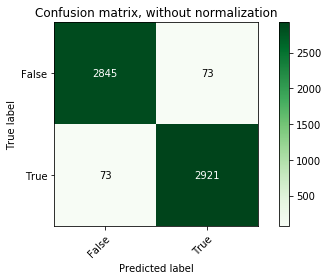

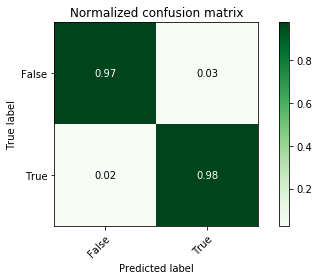

In [33]:
plot_confusion_matrix(y_test,pred.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred.detach().numpy(),[0,1], normalize=True)

In [34]:
full_p,full_r,full_a,full_f1 = evaluation_summary("Self Attention-Full", pred.detach().numpy(), y_test)

Evaluation for: Self Attention-Full
Classifier 'Self Attention-Full' has Acc=0.975 P=0.975 R=0.975 F1=0.975
              precision    recall  f1-score   support

         0.0      0.975     0.975     0.975      2918
         1.0      0.976     0.976     0.976      2994

    accuracy                          0.975      5912
   macro avg      0.975     0.975     0.975      5912
weighted avg      0.975     0.975     0.975      5912


Confusion matrix:
 [[2845   73]
 [  73 2921]]


In [35]:
# Calculate the AUC value of the result.
fpr, tpr, thresholds = roc_curve(y_test, pred.detach().numpy())
auc_full = auc(fpr, tpr)
print("Self Attention-Full AUC-",auc_full)

Self Attention-Full AUC- 0.9753003837238103


In [36]:
# Visualize the attention weights for this model.
test_last_idx = 15
wts = get_activation_wts(attention_model,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                            Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_cls[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))

visualize_attention(wts,x_test_pad[:test_last_idx],word_to_id,filename='attention_pol_full.html')

Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


##Sub-Model- Self Attention model using only Article and Claim

In [0]:
# Same model but it uses only article and claim as input.
class StructuredSelfAttention(torch.nn.Module):
    """
    The class is an implementation of the paper A Structured Self-Attentive Sentence Embedding including regularization
    and without pruning. Slight modifications have been done for speedup
    """
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()
        # Initialization of the required layers
        self.embeddings,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first.bias.data.fill_(0)
        self.linear_second = torch.nn.Linear(d_a,r)
        self.linear_second.bias.data.fill_(0)
        self.n_classes = n_classes
        
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)

        self.linear_final = torch.nn.Linear(lstm_hid_dim,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
          
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")
        
        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,xs,ys):
        embeddings = self.embeddings(x) # claim embedding
        embeddings_part_y = self.embeddings(y[:,:100]) # Article embedding taking the first 100 values
        main_embedding  = torch.cat((embeddings, embeddings_part_y), 1) #Combination of the two
        # Bi-LSTM layer
        outputs, self.hidden_state = self.lstm(main_embedding.view(self.batch_size,self.max_len,-1),self.hidden_state)  
        # Self-Attention mechanism    
        x = torch.tanh(self.linear_first(outputs))       
        x = self.linear_second(x)       
        x = self.softmax(x,1)       
        attention = x.transpose(1,2)  
        sentence_embeddings = attention@outputs

        # Same processing followed for article only.
        embeddings2 = self.embeddings2(y)    
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state)       
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2

        # Element-wise multiplication of the two outputs.
        ele_mul = sentence_embeddings * sentence_embeddings2
        # Average of the output.
        avg_sentence_embeddings = torch.sum(ele_mul,1)/self.r
        
        output = torch.sigmoid(self.linear_final(avg_sentence_embeddings))
        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
 
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [17]:
# Initialize and Train the model.
attention_model2 = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss2, acc2 = binary_classfication(attention_model2,train_loader=train_loader,epochs=3,use_regularization=True,C=params_set["C"],clip=params_set["clip"])


Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(0.6552, dtype=torch.float64)
Accuracy of the model 0.6914487092391305
Running EPOCH 2
avg_loss is tensor(0.2472, dtype=torch.float64)
Accuracy of the model 0.9475203804347826
Running EPOCH 3
avg_loss is tensor(0.1510, dtype=torch.float64)
Accuracy of the model 0.9815726902173914


In [18]:
# Accuracy of the test data
acc2, pred2 = evaluate(attention_model2, x_test_pad_cl, x_test_pad, x_test_pad_cls, x_test_pad_s, y_test)
print(acc2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.9700608930987822


Confusion matrix, without normalization
[[2832   86]
 [  91 2903]]
Normalized confusion matrix
[[0.97052776 0.02947224]
 [0.03039412 0.96960588]]


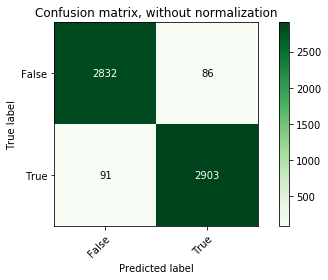

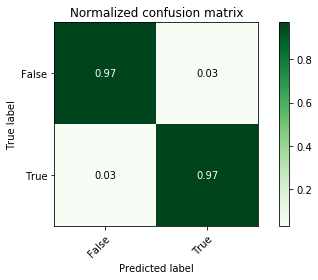

In [19]:
plot_confusion_matrix(y_test,pred2.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred2.detach().numpy(),[0,1], normalize=True)

In [20]:
art_cl_p,art_cl_r,art_cl_a,art_cl_f1 = evaluation_summary("Self Attention-Article and Claim", pred2.detach().numpy(), y_test)

Evaluation for: Self Attention-Article and Claim
Classifier 'Self Attention-Article and Claim' has Acc=0.970 P=0.970 R=0.970 F1=0.970
              precision    recall  f1-score   support

         0.0      0.971     0.969     0.970      2923
         1.0      0.970     0.971     0.970      2989

    accuracy                          0.970      5912
   macro avg      0.970     0.970     0.970      5912
weighted avg      0.970     0.970     0.970      5912


Confusion matrix:
 [[2832   86]
 [  91 2903]]


In [21]:
fpr, tpr, thresholds = roc_curve(y_test, pred2.detach().numpy())
auc_art_cl = auc(fpr, tpr)
print("Self Attention-Article_claim AUC-",auc_art_cl)

Self Attention-Article_claim AUC- 0.9700668185811879


In [22]:
# Visulaisation
test_last_idx = 15
wts2 = get_activation_wts(attention_model2,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                             Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_cls[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))
print(wts2.size())
visualize_attention(wts2,x_test_pad[:test_last_idx],word_to_id,filename='attention_art_cl.html')

torch.Size([15, 10, 150])
Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Sub Model- Using only Article

In [0]:
# Self attention class this time only using the Article.
class StructuredSelfAttention(torch.nn.Module):
    """
    The class is an implementation of the paper A Structured Self-Attentive Sentence Embedding including regularization
    and without pruning. Slight modifications have been done for speedup
    """
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()        
        self.n_classes = n_classes
        
        # Self Attention layers for Article
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)

        self.linear_final = torch.nn.Linear(lstm_hid_dim,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
          
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")
        
        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,xs,ys):
        # Article embedding
        embeddings2 = self.embeddings2(y)    
        # Bi-LSTM layer
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state)  
         # Self-Attention mechanism     
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2
        # Average of the output
        avg_sentence_embeddings = torch.sum(sentence_embeddings2,1)/self.r
        
        output = torch.sigmoid(self.linear_final(avg_sentence_embeddings))

        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
 
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [39]:
# Initialize and train the model
attention_model3 = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss, acc = binary_classfication(attention_model3,train_loader=train_loader,epochs=3,use_regularization=True,C=params_set["C"],clip=params_set["clip"])


Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(0.6027, dtype=torch.float64)
Accuracy of the model 0.7426970108695652
Running EPOCH 2
avg_loss is tensor(0.3171, dtype=torch.float64)
Accuracy of the model 0.9119395380434783
Running EPOCH 3
avg_loss is tensor(0.2324, dtype=torch.float64)
Accuracy of the model 0.9486667798913043


In [0]:
# Accuracy of the test data
acc3, pred3 = evaluate(attention_model3, x_test_pad_cl, x_test_pad, x_test_pad_cls, x_test_pad_s, y_test)
print(acc3)

0.8369418132611637


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Confusion matrix, without normalization
[[2334  612]
 [ 352 2614]]
Normalized confusion matrix
[[0.79226069 0.20773931]
 [0.11867835 0.88132165]]


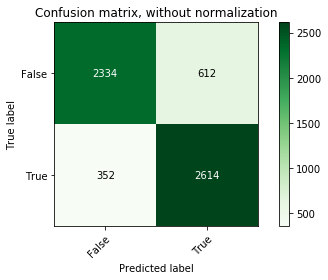

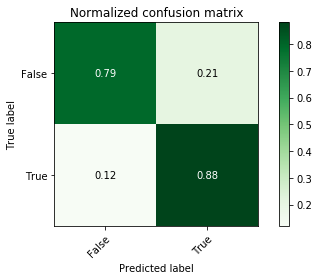

In [0]:
plot_confusion_matrix(y_test,pred3.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred3.detach().numpy(),[0,1], normalize=True)

In [0]:
art_p,art_r,art_a,art_f1 = evaluation_summary("Self Attention-Article only", pred3.detach().numpy(), y_test)

Evaluation for: Self Attention-Article only
Classifier 'Self Attention-Article only' has Acc=0.837 P=0.837 R=0.840 F1=0.837
              precision    recall  f1-score   support

         0.0      0.792     0.869     0.829      2686
         1.0      0.881     0.810     0.844      3226

    accuracy                          0.837      5912
   macro avg      0.837     0.840     0.837      5912
weighted avg      0.841     0.837     0.837      5912


Confusion matrix:
 [[2334  612]
 [ 352 2614]]


In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred3.detach().numpy())
auc_art = auc(fpr, tpr)
print("Self Attention-Article only AUC-",auc_art)

Self Attention-Article only AUC- 0.8367911688889561


In [0]:
# Visulaisation
test_last_idx = 15
wts3 = get_activation_wts(attention_model3,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                             Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_cls[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))
print(wts3.size())
visualize_attention(wts3,x_test_pad[:test_last_idx],word_to_id,filename='attention_art.html')

torch.Size([15, 10, 150])
Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Sub Model- Article and sources

In [0]:
# Self attention class uing only the article and article source
class StructuredSelfAttention(torch.nn.Module):
    """
    The class is an implementation of the paper A Structured Self-Attentive Sentence Embedding including regularization
    and without pruning. Slight modifications have been done for speedup
    """
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()       
        self.n_classes = n_classes
        
        # Self Attention layers for Article
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)
        
         # Embedding layers for sources
        self.embeddings3,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.embeddings4,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        
        self.linear_final = torch.nn.Linear(3*lstm_hid_dim,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
          
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")
        
        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,xs,ys):
        # Article embedding
        embeddings2 = self.embeddings2(y)    
        # Bi-LSTM layer
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state)  
        # Self-Attention mechanism     
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2
        # Average of the output.
        avg_sentence_embeddings = torch.sum(sentence_embeddings2,1)/self.r
        
        # Claim and article source embedding
        embeddings3 = self.embeddings3(xs)
        embeddings4 = self.embeddings4(ys) 
        # Average of the embeddings
        avg_csource_embeddings = torch.sum(embeddings3,1)/self.r
        avg_asource_embeddings = torch.sum(embeddings4,1)/self.r
        # Combined average of the sources and self-attention outputs.
        comb_avg = torch.cat((avg_sentence_embeddings, avg_csource_embeddings, avg_asource_embeddings), 1)
 
        output = torch.sigmoid(self.linear_final(comb_avg))
        
        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
 
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [0]:
# Initialize and Train the model
attention_model4 = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss, acc = binary_classfication(attention_model4,train_loader=train_loader,epochs=2,use_regularization=True,C=params_set["C"],clip=params_set["clip"])

Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(0.5091, dtype=torch.float64)
Accuracy of the model 0.7995499320652174
Running EPOCH 2
avg_loss is tensor(0.2537, dtype=torch.float64)
Accuracy of the model 0.9394955842391305


In [0]:
# Accuracy of the test data
acc4, pred4 = evaluate(attention_model4, x_test_pad_cl, x_test_pad, x_test_pad_cls, x_test_pad_s, y_test)
print(acc4)

0.8607916102841678


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Confusion matrix, without normalization
[[2650  296]
 [ 527 2439]]
Normalized confusion matrix
[[0.89952478 0.10047522]
 [0.17768038 0.82231962]]


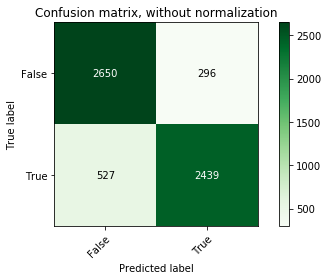

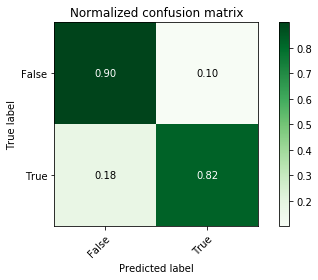

In [0]:
plot_confusion_matrix(y_test,pred4.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred4.detach().numpy(),[0,1], normalize=True)

In [0]:
arts_p,arts_r,arts_a,arts_f1 = evaluation_summary("Self Attention-Article and sources", pred4.detach().numpy(), y_test)

Evaluation for: Self Attention-Article and sources
Classifier 'Self Attention-Article and sources' has Acc=0.861 P=0.861 R=0.863 F1=0.861
              precision    recall  f1-score   support

         0.0      0.900     0.834     0.866      3177
         1.0      0.822     0.892     0.856      2735

    accuracy                          0.861      5912
   macro avg      0.861     0.863     0.861      5912
weighted avg      0.864     0.861     0.861      5912


Confusion matrix:
 [[2650  296]
 [ 527 2439]]


In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred4.detach().numpy())
auc_arts = auc(fpr, tpr)
print("Self Attention-Article_souces AUC-",auc_arts)

Self Attention-Article_souces AUC- 0.8609222008744499


In [0]:
# Visulaisation
test_last_idx = 15
wts4 = get_activation_wts(attention_model4,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                             Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_cls[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))
print(wts4.size())
visualize_attention(wts4,x_test_pad[:test_last_idx],word_to_id,filename='attention_art_sources.html')

torch.Size([15, 10, 150])
Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Full Model using Batchwise dot

In [0]:
# The full model buing rather than just using element-wise multiplication to combine the two self-attentions outputs, we use batch-wise dot product.
# The batch-wise dot product is a technique mentioned by lin et al.(2017) in their paper.
class StructuredSelfAttention(torch.nn.Module):
    """
    The class is an implementation of the paper A Structured Self-Attentive Sentence Embedding including regularization
    and without pruning. Slight modifications have been done for speedup
    """
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()
        # Model layers initialization.
        # Claim related layers
        self.embeddings,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first.bias.data.fill_(0)
        self.linear_second = torch.nn.Linear(d_a,r)
        self.linear_second.bias.data.fill_(0)
        self.n_classes = n_classes
        # Article related layers
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)
        # ources related layers
        self.embeddings3,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.embeddings4,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        
        self.linear_penul = torch.nn.Linear(3*lstm_hid_dim,8)
        self.linear_final = torch.nn.Linear(8,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
        
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")

        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,xs,ys):
        embeddings = self.embeddings(x) # claim embedding
        embeddings_part_y = self.embeddings(y[:,:100]) # article embedding uing first 100 values
        main_embedding  = torch.cat((embeddings, embeddings_part_y), 1) # combination of the two
        # Bi-LSTM layer
        outputs, self.hidden_state = self.lstm(main_embedding.view(self.batch_size,self.max_len,-1),self.hidden_state)  
        # Self-attention mechanism     
        x = torch.tanh(self.linear_first(outputs))       
        x = self.linear_second(x)       
        x = self.softmax(x,1)       
        attention = x.transpose(1,2)  
        sentence_embeddings = attention@outputs
        # Creation of a random weight matrix
        rand_wt = torch.from_numpy(np.random.rand(sentence_embeddings.shape[0], sentence_embeddings.shape[1],sentence_embeddings.shape[1])) 
        # Multiply the output of the the weight matrix and self-attention output using batch-wise multiplication 
        factor_rel1 = torch.bmm(sentence_embeddings.transpose(2,1), rand_wt.float()).transpose(2,1)

        # Same process is followed for article only input.
        embeddings2 = self.embeddings2(y)    
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state)       
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2
        
        rand_wt2 = torch.from_numpy(np.random.rand(sentence_embeddings2.shape[0], sentence_embeddings2.shape[1],sentence_embeddings2.shape[1]))
        factor_rel2 = torch.bmm(sentence_embeddings2.transpose(2,1), rand_wt2.float()).transpose(2,1)
        # Take element-wise multiplication of the two outputs of BMM.
        ele_mul = factor_rel1 * factor_rel2
        # Average of the output
        avg_sentence_embeddings = torch.sum(ele_mul,1)/self.r

        # Claim and article embeddings
        embeddings3 = self.embeddings3(xs)
        embeddings4 = self.embeddings4(ys) 
        # Average of the embeddings
        avg_csource_embeddings = torch.sum(embeddings3,1)/self.r
        avg_asource_embeddings = torch.sum(embeddings4,1)/self.r
        # Combined average of all three averages
        comb_avg = torch.cat((avg_sentence_embeddings, avg_csource_embeddings, avg_asource_embeddings), 1)
        
        dense1 = self.linear_penul(comb_avg) 
        output = torch.sigmoid(self.linear_final(dense1))
        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
 
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [0]:
# Initialize and train the output
attention_model5 = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss, acc = binary_classfication(attention_model5,train_loader=train_loader,epochs=2,use_regularization=False,C=params_set["C"],clip=params_set["clip"])


Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(1.2289, dtype=torch.float64)
Accuracy of the model 0.7375594429347826
Running EPOCH 2
avg_loss is tensor(0.0683, dtype=torch.float64)
Accuracy of the model 0.974991508152174


In [0]:
# Accuracy of the test data
acc5, pred5 = evaluate(attention_model5, x_test_pad_cl, x_test_pad, x_test_pad_cls, x_test_pad_s, y_test)
print(acc5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.9582205683355887


Confusion matrix, without normalization
[[2821  125]
 [ 122 2844]]
Normalized confusion matrix
[[0.95756959 0.04243041]
 [0.04113284 0.95886716]]


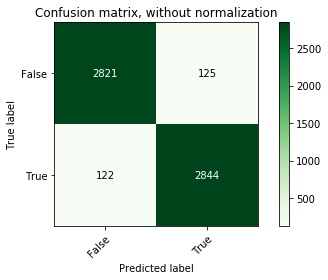

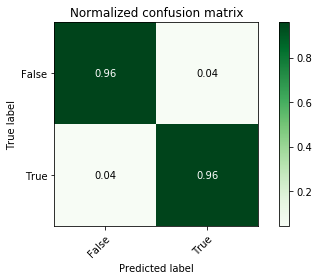

In [0]:
plot_confusion_matrix(y_test,pred5.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred5.detach().numpy(),[0,1], normalize=True)

In [0]:
batch_p,batch_r,batch_a,batch_f1 = evaluation_summary("Self Attention-Article and sources", pred5.detach().numpy(), y_test)

Evaluation for: Self Attention-Article and sources
Classifier 'Self Attention-Article and sources' has Acc=0.958 P=0.958 R=0.958 F1=0.958
              precision    recall  f1-score   support

         0.0      0.958     0.959     0.958      2943
         1.0      0.959     0.958     0.958      2969

    accuracy                          0.958      5912
   macro avg      0.958     0.958     0.958      5912
weighted avg      0.958     0.958     0.958      5912


Confusion matrix:
 [[2821  125]
 [ 122 2844]]


In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred5.detach().numpy())
auc_batch = auc(fpr, tpr)
print("Self Attention-Article_souces AUC-",auc_batch)

Self Attention-Article_souces AUC- 0.9582183735194847


In [0]:
# Visulaisation
test_last_idx = 15
wts5 = get_activation_wts(attention_model5,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                             Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_cls[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))
print(wts5.size())
visualize_attention(wts5,x_test_pad[:test_last_idx],word_to_id,filename='attention_batch_dot.html')

torch.Size([15, 10, 150])
Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


##Evaluation on Unique Claims

Due to the problem of experimental bias introduced into the model, we test the performance of the Hybrid model on unique claims. This bias is introduced because a claim can be associated with many articles and hence can be repeated in traning and test data making it seen data for the model when testing.

In [37]:
# For full model
x_test_or['bin_cred_label'] = y_test
x_test_or['pred_label_full'] = pred.detach().numpy()
unique_test_or2 = x_test_or[~x_test_or['claim_text'].isin(x_train_or['claim_text'])]
unique_test_or2.head()

,cred_label,claim_id,claim_text,claim_source,article,article_source,bin_cred_label,pred_label2,pred_label_full
11976,Pants on Fire!,2017_apr_11_sean-spicer_did-adolf-hitler-use-c...,says adolf hitler didnt even using chemical we...,sean spicer,even hitler didnt sink to using chemical weapo...,independent.co.uk,0.0,0.0,0.0
2760,Half-True,2010_dec_03_michael-steele_rnc-chair-michael-s...,elections chairman since 1938,michael steele,strengthening constitutional publications the ...,ashbrook.org,1.0,1.0,0.0
24400,False,2011_jun_28_jim-demint_jim-demint-says-federal...,weve got revenue ever,jim demint,12th out of 13 conference usa athletic departm...,hattiesburgamerican.com,0.0,0.0,0.0
8775,False,2010_nov_11_rand-paul_rand-paul-says-federal-w...,average federal employee makes year average pr...,rand paul,represent federal workers say on average they ...,factcheck.org,0.0,1.0,1.0
15203,False,2011_jan_07_steny-hoyer_steny-hoyer-says-gop-d...,preparing rules package 112th congress gop no ...,steny hoyer,online ahead of a slated jan 4 organizational ...,washingtonpost.com,0.0,0.0,0.0


In [0]:
bin_pred2=unique_test_or2['bin_cred_label'].tolist()
pred_val2=unique_test_or2['pred_label_full'].tolist()

Confusion matrix, without normalization
[[54 40]
 [28 37]]
Normalized confusion matrix
[[0.57446809 0.42553191]
 [0.43076923 0.56923077]]


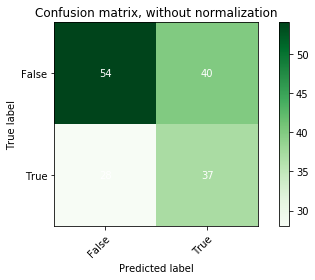

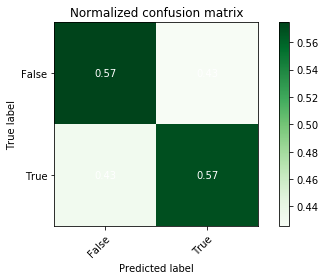

In [39]:
plot_confusion_matrix(bin_pred2,pred_val2,[0,1])
plot_confusion_matrix(bin_pred2,pred_val2,[0,1], normalize=True)

In [40]:
ac_p,ac_r,ac_a,ac_f1 = evaluation_summary("Self Attention-article and claim", pred_val2, bin_pred2)

Evaluation for: Self Attention-article and claim
Classifier 'Self Attention-article and claim' has Acc=0.572 P=0.572 R=0.570 F1=0.567
              precision    recall  f1-score   support

         0.0      0.574     0.659     0.614        82
         1.0      0.569     0.481     0.521        77

    accuracy                          0.572       159
   macro avg      0.572     0.570     0.567       159
weighted avg      0.572     0.572     0.569       159


Confusion matrix:
 [[54 40]
 [28 37]]


In [41]:
fpr, tpr, thresholds = roc_curve(bin_pred2, pred_val2)
auc_arts = auc(fpr, tpr)
print("Self Attention-Article_souces AUC-",auc_arts)

Self Attention-Article_souces AUC- 0.5718494271685761


In [29]:
label_counts = unique_test_or2['bin_cred_label'].value_counts()
print(label_counts.describe())
top_labels = label_counts.nlargest(5)
top_labels_list = top_labels.index.tolist()
print(top_labels)

count     2.000000
mean     79.500000
std      20.506097
min      65.000000
25%      72.250000
50%      79.500000
75%      86.750000
max      94.000000
Name: bin_cred_label, dtype: float64
0.0    94
1.0    65
Name: bin_cred_label, dtype: int64


In [30]:
incorrect2 = unique_test_or2[unique_test_or2['bin_cred_label']!=unique_test_or2['pred_label_full'].astype(int)]
incorrect2

,cred_label,claim_id,claim_text,claim_source,article,article_source,bin_cred_label,pred_label_full
8775,False,2010_nov_11_rand-paul_rand-paul-says-federal-w...,average federal employee makes year average pr...,rand paul,represent federal workers say on average they ...,factcheck.org,0.0,1.0
4483,Mostly False,2011_jun_24_tim-pawlenty_pawlenty-says-obama-g...,says president barack obama promised would cut...,tim pawlenty,long after that that i lost interest i would r...,wordpress.com,0.0,1.0
18331,True,2008_jan_06_hillary-clinton_lobbyists-live-in-...,sen obamas chair new hampshire lobbyist lobbie...,hillary clinton,the defensive about her husband when edwards a...,go.com,1.0,0.0
18203,Mostly False,2017_apr_27_donald-trump_did-trade-deficit-cau...,us recorded slowest economic growth five years...,donald trump,and has continued to complain about it and the...,ifashops.com,0.0,1.0
1857,Mostly False,2016_feb_03_ted-cruz_ted-cruz-says-median-afri...,eight years ronald reagan median income rose 5000,ted cruz,perkins has calculated that black unemployment...,dailysignal.com,0.0,1.0
8610,Half-True,244.json,says impressive education record republican ca...,mike huckabee,the republican candidates record on higher edu...,educationdive.com,1.0,0.0
2786,Pants on Fire!,2010_dec_16_tim-pawlenty_tim-pawlenty-repeats-...,since january 2008 private sector lost nearly ...,tim pawlenty,up to 24 days of unpaid furlough days while ou...,chicagotribune.com,0.0,1.0
25902,Half-True,2009_nov_06_mike-pence_us-rep-mike-pence-says-...,result house republican bill nonpartisan congr...,mike pence,a package seemingly meant to address the probl...,talkingpointsmemo.com,1.0,0.0
10011,Pants on Fire!,2011_mar_04_glenn-beck_glenn-beck-says-first-l...,says michelle obama 43 people staff nancy reag...,glenn beck,has been no recent addition of a personal shop...,mediamatters.org,0.0,1.0
1517,Pants on Fire!,2010_jan_28_nancy-pfotenhauer_health-care-refo...,presidents health care proposals cause america...,nancy pfotenhauer,ones that are looking at massive tax increases...,google.com,0.0,1.0


In [0]:
# Write to csv
unique_test_or2.to_csv('op_attn_pol_full.csv', sep='\t')

In [24]:
# For Art_claim model
x_test_or['pred_label2'] = pred2.detach().numpy()
unique_test_or3 = x_test_or[~x_test_or['claim_text'].isin(x_train_or['claim_text'])]
unique_test_or3.head()

,cred_label,claim_id,claim_text,claim_source,article,article_source,bin_cred_label,pred_label2
11976,Pants on Fire!,2017_apr_11_sean-spicer_did-adolf-hitler-use-c...,says adolf hitler didnt even using chemical we...,sean spicer,even hitler didnt sink to using chemical weapo...,independent.co.uk,0.0,0.0
2760,Half-True,2010_dec_03_michael-steele_rnc-chair-michael-s...,elections chairman since 1938,michael steele,strengthening constitutional publications the ...,ashbrook.org,1.0,1.0
24400,False,2011_jun_28_jim-demint_jim-demint-says-federal...,weve got revenue ever,jim demint,12th out of 13 conference usa athletic departm...,hattiesburgamerican.com,0.0,0.0
8775,False,2010_nov_11_rand-paul_rand-paul-says-federal-w...,average federal employee makes year average pr...,rand paul,represent federal workers say on average they ...,factcheck.org,0.0,1.0
15203,False,2011_jan_07_steny-hoyer_steny-hoyer-says-gop-d...,preparing rules package 112th congress gop no ...,steny hoyer,online ahead of a slated jan 4 organizational ...,washingtonpost.com,0.0,0.0


In [0]:
bin_pred3=unique_test_or3['bin_cred_label'].tolist()
pred_val3=unique_test_or3['pred_label2'].tolist()

Confusion matrix, without normalization
[[59 35]
 [29 36]]
Normalized confusion matrix
[[0.62765957 0.37234043]
 [0.44615385 0.55384615]]


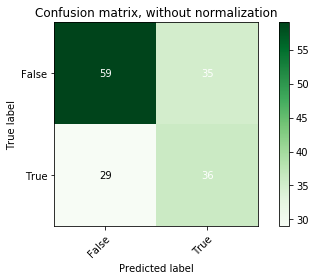

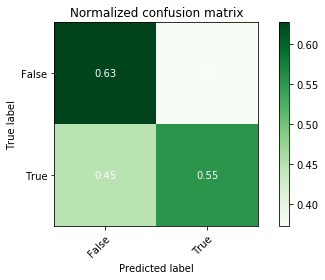

In [26]:
plot_confusion_matrix(bin_pred3,pred_val3,[0,1])
plot_confusion_matrix(bin_pred3,pred_val3,[0,1], normalize=True)

In [27]:
ac_p,ac_r,ac_a,ac_f1 = evaluation_summary("Self Attention-article and claim", pred_val3, bin_pred3)

Evaluation for: Self Attention-article and claim
Classifier 'Self Attention-article and claim' has Acc=0.597 P=0.591 R=0.589 F1=0.589
              precision    recall  f1-score   support

         0.0      0.628     0.670     0.648        88
         1.0      0.554     0.507     0.529        71

    accuracy                          0.597       159
   macro avg      0.591     0.589     0.589       159
weighted avg      0.595     0.597     0.595       159


Confusion matrix:
 [[59 35]
 [29 36]]


In [28]:
fpr, tpr, thresholds = roc_curve(bin_pred3, pred_val3)
auc_arts = auc(fpr, tpr)
print("Self Attention-Article_souces AUC-",auc_arts)

Self Attention-Article_souces AUC- 0.5907528641571195


In [29]:
label_counts = unique_test_or3['bin_cred_label'].value_counts()
print(label_counts.describe())
top_labels = label_counts.nlargest(5)
top_labels_list = top_labels.index.tolist()
print(top_labels)

count     2.000000
mean     79.500000
std      20.506097
min      65.000000
25%      72.250000
50%      79.500000
75%      86.750000
max      94.000000
Name: bin_cred_label, dtype: float64
0.0    94
1.0    65
Name: bin_cred_label, dtype: int64


In [0]:
incorrect3 = unique_test_or2[unique_test_or3['bin_cred_label']!=unique_test_or3['pred_label2'].astype(int)]
incorrect3

,cred_label,claim_id,claim_text,claim_source,article,article_source,bin_cred_label,pred_label_full
5975,Mostly True,2015_jun_04_mike-huckabee_mike-huckabee-says-o...,sixty million americans depend social security...,mike huckabee,percent of our retirement income will come fro...,tampabay.com,1.0,0.0
26008,Mostly False,2009_apr_16_gus-bilirakis_dhs-report-right-win...,department homeland view returning military ve...,gus bilirakis,michelle widely cited blog post cried out cong...,salon.com,0.0,1.0
14208,False,2011_feb_23_state-democratic-party-wisconsin_l...,five states outlaw collective bargaining teach...,democratic party of wisconsin,the liberal world quits on kids how hopeless i...,dailyhowler.com,0.0,1.0
26123,False,2011_apr_11_donald-trump_libya-sells-most-its-...,libya supplies oil china get no oil libya,donald trump,we get no oil from libya false has no clue how...,datacentertalk.io,0.0,1.0
3186,False,2012_may_14_barack-obama_obama-ad-says-romney-...,says mitt romney would deny gay people right a...,barack obama,legalize gay unions after the democrat dominat...,aboutmittromney.com,0.0,1.0
21173,Mostly True,2008_may_07_john-mccain_his-percentage-is-righ...,friend increased size government 40 percent la...,john mccain,up much faster than private sector pay a 1992 ...,fee.org,1.0,0.0
20803,Pants on Fire!,2010_may_05_jd-hayworth_rival-says-hes-forced-...,two weeks ago john mccain leading proponent am...,j.d. hayworth,clinton jd hayworth 2 the massachusetts suprem...,noonehastherighttoremainstupid.blogspot.com,0.0,1.0
24097,False,2011_jul_29_bill-oreilly_bill-oreilly-says-pov...,since 1965 united states spent untold trillion...,bill o'reilly,false rating for that citing a study by the ta...,bostonmagazine.com,0.0,1.0
28158,False,2016_jan_26_bernie-s_bernie-sanders-says-he-po...,almost polls come suggest much stronger candid...,bernie sanders,decided that although hi pants are not quite o...,mediaite.com,0.0,1.0
27033,Pants on Fire!,2010_jan_20_rush-limbaugh_limbaugh-claims-whit...,high administrative costs donate haiti relief ...,rush limbaugh,the world politifact national on thursday june...,quora.com,0.0,0.0


In [0]:
# Write to csv
unique_test_or3.to_csv('op_attn_pol_artcl.csv', sep='\t')

## Bibliography

Kashyap Popat, Subhabrata Mukherjee, Andrew Yates and Gerhard Weikum, <i>DeClarE: Debunking Fake News and False Claims using Evidence-Aware Deep Learning</i>, Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, Pages 22-32, 2018.

Zhouhan Lin, Minwei Feng, Cicero Nogueira dos Santos, Mo Yu, Bing Xiang, Bowen Zhou and Yoshua Bengio,<i> A Structured Self-attentive Sentence Embedding</i>, ICLR, 2017.